In [42]:
%load_ext autoreload
%autoreload 2
import torch

In [7]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


In [8]:
SAMPLE_DATA_FILE = 'data/sample.csv'
LABELS_OUTPUT = 'data/labels_multi_hot.pt'
W2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/w2v_embedded_visit_notes.pt'
D2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/d2v_embedded_visit_notes.pt'

In [9]:
import pandas as pd

# Printing raw data from data file
df = pd.read_csv(SAMPLE_DATA_FILE)
print(df)

       case_num  subject_id icd9_code  \
0             0           0   S8264XJ   
1             0           1   S36501D   
2             0           2   T484X2A   
3             0           3   S86301D   
4             0           4     M9948   
...         ...         ...       ...   
42141         9       95330   S82854H   
42142         9       95331     A1839   
42143         9       95332    M12842   
42144         9       95333   M84522S   
42145         9       95334   O6022X1   

                                                    text  
0      17-year-old male, has come to the student heal...  
1      17 yo male with recurrent palpitations for the...  
2      Dillon Cleveland is a 17 y.o. male patient wit...  
3      a 17 yo m c/o palpitation started 3 mos ago; \...  
4      17yo male with no pmh here for evaluation of p...  
...                                                  ...  
42141  Ms. Madden is a 20 yo female presenting w/ the...  
42142  A 20 YO F CAME COMPLAIN A DU

In [10]:
# Load embedded visit notes
d2v_embedded_visit_notes = torch.load(D2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
w2v_embedded_visit_notes = torch.load(W2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
labels = torch.load(LABELS_OUTPUT, weights_only=True)
print(d2v_embedded_visit_notes.shape)
print(w2v_embedded_visit_notes.shape)
print(labels.shape)

D2V_VECTOR_SIZE = d2v_embedded_visit_notes.shape[1]
W2V_VECTOR_SIZE = w2v_embedded_visit_notes.shape[1]

torch.Size([52722, 128])
torch.Size([52722, 100, 700])
torch.Size([52722, 6918])


In [11]:
embedded_visit_notes = [(d2v, w2v) for d2v, w2v in zip(d2v_embedded_visit_notes, w2v_embedded_visit_notes)]

In [37]:
import numpy as np
from torch.utils.data import DataLoader

from utils import ICD9_Dataset


percentage = 0.5
batch_size = 50

num_samples = int(np.floor(percentage * labels.shape[0]))
train_samples = int(np.floor(0.7 * num_samples))
leftovers = num_samples - train_samples
valid_samples = train_samples + int(np.floor(0.5*leftovers))

print("Total Samples: ", str(num_samples))
print("Train Samples: ", str(train_samples))
print("Valid Samples: ", str(valid_samples - train_samples))
print("Test Samples: ", str(num_samples - valid_samples))


# Initialize Dataset
train_dataset = ICD9_Dataset(embedded_visit_notes[:train_samples],
                              labels[:train_samples])
valid_dataset = ICD9_Dataset(embedded_visit_notes[train_samples:valid_samples],
                            labels[train_samples:valid_samples])
test_dataset = ICD9_Dataset(embedded_visit_notes[valid_samples:num_samples],
                              labels[valid_samples:num_samples])
# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Total Samples:  26361
Train Samples:  18452
Valid Samples:  3954
Test Samples:  3955


In [13]:
sample_set = embedded_visit_notes[0:5]
sample_set_d2v, sample_set_w2v = zip(*sample_set)
sample_set_d2v = torch.stack(sample_set_d2v)  
sample_set_w2v = torch.stack(sample_set_w2v)
print(sample_set_d2v.shape)
print(sample_set_w2v.shape)

torch.Size([5, 128])
torch.Size([5, 100, 700])


In [14]:
# Use CNN to process sample set of vector

import cnn 

my_cnn = cnn.CNN(device=device).to(device)

x = sample_set_w2v.to(device)
print(x.shape)

output = my_cnn.forward(x)
print(output.shape)


torch.Size([5, 100, 700])
torch.Size([5, 192])


In [15]:
# Use D2V Linear Layer to process sample set of vector

import importlib
import d2v_fc 

importlib.reload(d2v_fc)

dv2_model = d2v_fc.D2VFullyConnectedLayer(device=device).to(device)

x = sample_set_d2v.to(device)
print(x.shape)

output = dv2_model.forward(x)
print(output.shape)

torch.Size([5, 128])
torch.Size([5, 128])


In [16]:
# Use Combined Model to process sample set of data

import importlib
import icd9_dl_model 

importlib.reload(icd9_dl_model)
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

x = (sample_set_d2v, sample_set_w2v)

output = model.forward(x)
print(output)

tensor([[ 0.4491, -0.3519,  0.1775,  ..., -0.6958, -0.8233, -0.6295],
        [-0.8394, -0.1335, -1.2433,  ..., -0.8375,  0.0779, -0.6620],
        [ 0.8663, -0.2735,  0.1661,  ..., -1.4716, -0.1585,  0.3135],
        [-0.0736, -1.0872, -0.4770,  ..., -0.5016, -1.8017,  0.0959],
        [ 0.6756,  0.1269, -0.1067,  ..., -1.5061,  0.2839, -0.0291]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [46]:
%load_ext autoreload
%autoreload 2
from utils import train, evaluate, plot_curves
import torch.nn as nn

def train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename='', epochs=10, threshold=0.2):
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []
    for epoch_idx in range(epochs):
        print("-----------------------------------")
        print("Epoch %d" % (epoch_idx+1))
        print("-----------------------------------")

        train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)

        if scheduler:
            scheduler.step(train_loss)

        valid_accuracy, valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device=device, threshold=threshold)

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, valid_loss))
        print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, valid_accuracy))
        print("Training Precision: %.4f. Validation Precision: %.4f. " % (train_precision, valid_precision))
        print("Training Recall: %.4f. Validation Recall: %.4f. " % (train_recall, valid_recall))
        print("Training F1: %.4f. Validation F1: %.4f. " % (train_f1, valid_f1))

    plot_curves(train_accuracies, valid_accuracies, "Accuracy", filename, output_dir='outputs/')
    plot_curves(train_losses, valid_losses, "Loss", filename, output_dir='outputs/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 62.78it/s]


Training Loss: 74.3539. Validation Loss: 70.1019. 
Training Accuracy: 0.9466. Validation Accuracy: 0.9437. 
Training Precision: 0.0237. Validation Precision: 0.0249. 
Training Recall: 0.7649. Validation Recall: 0.8415. 
Training F1: 0.0460. Validation F1: 0.0483. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 83.17it/s]


Training Loss: 67.8355. Validation Loss: 68.7136. 
Training Accuracy: 0.9401. Validation Accuracy: 0.9375. 
Training Precision: 0.0240. Validation Precision: 0.0234. 
Training Recall: 0.8691. Validation Recall: 0.8741. 
Training F1: 0.0468. Validation F1: 0.0456. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 82.74it/s]


Training Loss: 66.0547. Validation Loss: 67.6938. 
Training Accuracy: 0.9349. Validation Accuracy: 0.9350. 
Training Precision: 0.0229. Validation Precision: 0.0227. 
Training Recall: 0.8989. Validation Recall: 0.8860. 
Training F1: 0.0447. Validation F1: 0.0442. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 81.63it/s]


Training Loss: 64.9673. Validation Loss: 67.6461. 
Training Accuracy: 0.9312. Validation Accuracy: 0.9307. 
Training Precision: 0.0221. Validation Precision: 0.0216. 
Training Recall: 0.9170. Validation Recall: 0.8953. 
Training F1: 0.0431. Validation F1: 0.0421. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 81.65it/s]


Training Loss: 64.2530. Validation Loss: 67.8854. 
Training Accuracy: 0.9284. Validation Accuracy: 0.9282. 
Training Precision: 0.0216. Validation Precision: 0.0210. 
Training Recall: 0.9303. Validation Recall: 0.8995. 
Training F1: 0.0421. Validation F1: 0.0411. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 77.21it/s]


Training Loss: 63.7174. Validation Loss: 67.3215. 
Training Accuracy: 0.9265. Validation Accuracy: 0.9281. 
Training Precision: 0.0212. Validation Precision: 0.0209. 
Training Recall: 0.9401. Validation Recall: 0.9011. 
Training F1: 0.0416. Validation F1: 0.0408. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 80.20it/s]


Training Loss: 63.3113. Validation Loss: 68.0124. 
Training Accuracy: 0.9250. Validation Accuracy: 0.9248. 
Training Precision: 0.0210. Validation Precision: 0.0202. 
Training Recall: 0.9468. Validation Recall: 0.9032. 
Training F1: 0.0411. Validation F1: 0.0394. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 80.61it/s]


Training Loss: 62.8135. Validation Loss: 67.8679. 
Training Accuracy: 0.9240. Validation Accuracy: 0.9232. 
Training Precision: 0.0208. Validation Precision: 0.0197. 
Training Recall: 0.9518. Validation Recall: 0.9053. 
Training F1: 0.0407. Validation F1: 0.0386. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 80.42it/s]


Training Loss: 62.4113. Validation Loss: 67.4257. 
Training Accuracy: 0.9233. Validation Accuracy: 0.9240. 
Training Precision: 0.0207. Validation Precision: 0.0199. 
Training Recall: 0.9562. Validation Recall: 0.9085. 
Training F1: 0.0406. Validation F1: 0.0390. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 78.11it/s]


Training Loss: 61.9663. Validation Loss: 67.8353. 
Training Accuracy: 0.9230. Validation Accuracy: 0.9226. 
Training Precision: 0.0207. Validation Precision: 0.0196. 
Training Recall: 0.9596. Validation Recall: 0.9075. 
Training F1: 0.0405. Validation F1: 0.0383. 


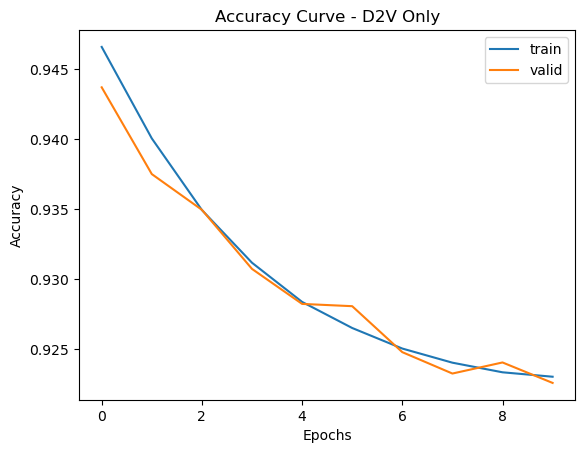

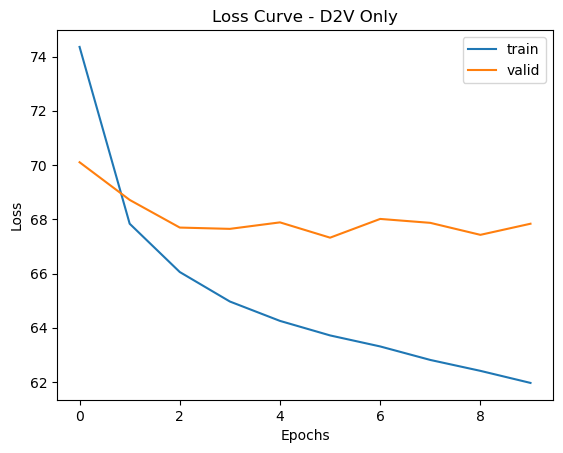

In [ ]:
# D2V Only

import icd9_dl_model

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="d2v").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "D2V Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:04<00:00, 17.09it/s]


Training Loss: 75.4300. Validation Loss: 71.9899. 
Training Accuracy: 0.9562. Validation Accuracy: 0.9679. 
Training Precision: 0.0288. Validation Precision: 0.0375. 
Training Recall: 0.7091. Validation Recall: 0.7259. 
Training F1: 0.0553. Validation F1: 0.0714. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.11it/s]


Training Loss: 70.0778. Validation Loss: 69.4166. 
Training Accuracy: 0.9719. Validation Accuracy: 0.9765. 
Training Precision: 0.0430. Validation Precision: 0.0507. 
Training Recall: 0.7289. Validation Recall: 0.7242. 
Training F1: 0.0812. Validation F1: 0.0948. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.00it/s]


Training Loss: 67.3779. Validation Loss: 67.6204. 
Training Accuracy: 0.9780. Validation Accuracy: 0.9808. 
Training Precision: 0.0543. Validation Precision: 0.0607. 
Training Recall: 0.7284. Validation Recall: 0.7133. 
Training F1: 0.1010. Validation F1: 0.1117. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.29it/s]


Training Loss: 65.6217. Validation Loss: 67.2039. 
Training Accuracy: 0.9820. Validation Accuracy: 0.9844. 
Training Precision: 0.0647. Validation Precision: 0.0716. 
Training Recall: 0.7153. Validation Recall: 0.6830. 
Training F1: 0.1186. Validation F1: 0.1294. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.38it/s]


Training Loss: 64.2855. Validation Loss: 66.6378. 
Training Accuracy: 0.9855. Validation Accuracy: 0.9878. 
Training Precision: 0.0775. Validation Precision: 0.0864. 
Training Recall: 0.6925. Validation Recall: 0.6485. 
Training F1: 0.1392. Validation F1: 0.1524. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.80it/s]


Training Loss: 62.8461. Validation Loss: 66.5223. 
Training Accuracy: 0.9885. Validation Accuracy: 0.9902. 
Training Precision: 0.0930. Validation Precision: 0.1017. 
Training Recall: 0.6598. Validation Recall: 0.6066. 
Training F1: 0.1628. Validation F1: 0.1738. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.55it/s]


Training Loss: 61.8147. Validation Loss: 66.6290. 
Training Accuracy: 0.9909. Validation Accuracy: 0.9927. 
Training Precision: 0.1116. Validation Precision: 0.1252. 
Training Recall: 0.6218. Validation Recall: 0.5484. 
Training F1: 0.1887. Validation F1: 0.2034. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.54it/s]


Training Loss: 60.7647. Validation Loss: 67.3616. 
Training Accuracy: 0.9930. Validation Accuracy: 0.9943. 
Training Precision: 0.1349. Validation Precision: 0.1499. 
Training Recall: 0.5753. Validation Recall: 0.4935. 
Training F1: 0.2179. Validation F1: 0.2289. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.64it/s]


Training Loss: 59.9680. Validation Loss: 66.8796. 
Training Accuracy: 0.9944. Validation Accuracy: 0.9954. 
Training Precision: 0.1608. Validation Precision: 0.1737. 
Training Recall: 0.5348. Validation Recall: 0.4484. 
Training F1: 0.2462. Validation F1: 0.2493. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.04it/s]


Training Loss: 59.1145. Validation Loss: 67.4960. 
Training Accuracy: 0.9955. Validation Accuracy: 0.9963. 
Training Precision: 0.1867. Validation Precision: 0.2061. 
Training Recall: 0.4948. Validation Recall: 0.4036. 
Training F1: 0.2699. Validation F1: 0.2710. 
-----------------------------------
Epoch 11
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.10it/s]


Training Loss: 58.5910. Validation Loss: 66.7381. 
Training Accuracy: 0.9961. Validation Accuracy: 0.9966. 
Training Precision: 0.2104. Validation Precision: 0.2167. 
Training Recall: 0.4703. Validation Recall: 0.3909. 
Training F1: 0.2896. Validation F1: 0.2771. 
-----------------------------------
Epoch 12
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 37.60it/s]


Training Loss: 58.0129. Validation Loss: 67.9462. 
Training Accuracy: 0.9964. Validation Accuracy: 0.9968. 
Training Precision: 0.2226. Validation Precision: 0.2310. 
Training Recall: 0.4595. Validation Recall: 0.3607. 
Training F1: 0.2985. Validation F1: 0.2801. 
-----------------------------------
Epoch 13
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.90it/s]


Training Loss: 57.6587. Validation Loss: 67.5920. 
Training Accuracy: 0.9965. Validation Accuracy: 0.9969. 
Training Precision: 0.2333. Validation Precision: 0.2340. 
Training Recall: 0.4551. Validation Recall: 0.3647. 
Training F1: 0.3070. Validation F1: 0.2837. 
-----------------------------------
Epoch 14
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.24it/s]


Training Loss: 57.4036. Validation Loss: 67.8117. 
Training Accuracy: 0.9967. Validation Accuracy: 0.9970. 
Training Precision: 0.2420. Validation Precision: 0.2431. 
Training Recall: 0.4511. Validation Recall: 0.3502. 
Training F1: 0.3137. Validation F1: 0.2856. 
-----------------------------------
Epoch 15
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 30.44it/s]


Training Loss: 57.0086. Validation Loss: 68.2097. 
Training Accuracy: 0.9968. Validation Accuracy: 0.9971. 
Training Precision: 0.2499. Validation Precision: 0.2472. 
Training Recall: 0.4495. Validation Recall: 0.3493. 
Training F1: 0.3195. Validation F1: 0.2883. 
-----------------------------------
Epoch 16
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.14it/s]


Training Loss: 56.8176. Validation Loss: 68.4554. 
Training Accuracy: 0.9968. Validation Accuracy: 0.9971. 
Training Precision: 0.2553. Validation Precision: 0.2507. 
Training Recall: 0.4516. Validation Recall: 0.3500. 
Training F1: 0.3247. Validation F1: 0.2906. 
-----------------------------------
Epoch 17
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.21it/s]


Training Loss: 56.5284. Validation Loss: 68.4573. 
Training Accuracy: 0.9969. Validation Accuracy: 0.9972. 
Training Precision: 0.2606. Validation Precision: 0.2539. 
Training Recall: 0.4503. Validation Recall: 0.3406. 
Training F1: 0.3285. Validation F1: 0.2891. 
-----------------------------------
Epoch 18
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.08it/s]


Training Loss: 56.3949. Validation Loss: 68.6001. 
Training Accuracy: 0.9969. Validation Accuracy: 0.9972. 
Training Precision: 0.2637. Validation Precision: 0.2572. 
Training Recall: 0.4518. Validation Recall: 0.3391. 
Training F1: 0.3316. Validation F1: 0.2908. 
-----------------------------------
Epoch 19
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.89it/s]


Training Loss: 56.1962. Validation Loss: 68.9503. 
Training Accuracy: 0.9969. Validation Accuracy: 0.9972. 
Training Precision: 0.2659. Validation Precision: 0.2547. 
Training Recall: 0.4566. Validation Recall: 0.3411. 
Training F1: 0.3345. Validation F1: 0.2899. 
-----------------------------------
Epoch 20
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.63it/s]


Training Loss: 55.9974. Validation Loss: 68.7336. 
Training Accuracy: 0.9969. Validation Accuracy: 0.9972. 
Training Precision: 0.2669. Validation Precision: 0.2612. 
Training Recall: 0.4608. Validation Recall: 0.3400. 
Training F1: 0.3365. Validation F1: 0.2938. 
-----------------------------------
Epoch 21
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.04it/s]


Training Loss: 55.9204. Validation Loss: 69.0130. 
Training Accuracy: 0.9970. Validation Accuracy: 0.9972. 
Training Precision: 0.2709. Validation Precision: 0.2582. 
Training Recall: 0.4620. Validation Recall: 0.3400. 
Training F1: 0.3398. Validation F1: 0.2919. 
-----------------------------------
Epoch 22
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.96it/s]


Training Loss: 55.8082. Validation Loss: 69.5438. 
Training Accuracy: 0.9970. Validation Accuracy: 0.9972. 
Training Precision: 0.2717. Validation Precision: 0.2610. 
Training Recall: 0.4620. Validation Recall: 0.3456. 
Training F1: 0.3403. Validation F1: 0.2946. 
-----------------------------------
Epoch 23
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.95it/s]


Training Loss: 55.5971. Validation Loss: 69.4028. 
Training Accuracy: 0.9970. Validation Accuracy: 0.9973. 
Training Precision: 0.2714. Validation Precision: 0.2611. 
Training Recall: 0.4663. Validation Recall: 0.3354. 
Training F1: 0.3417. Validation F1: 0.2921. 
-----------------------------------
Epoch 24
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.15it/s]


Training Loss: 55.4346. Validation Loss: 70.3383. 
Training Accuracy: 0.9970. Validation Accuracy: 0.9972. 
Training Precision: 0.2737. Validation Precision: 0.2579. 
Training Recall: 0.4687. Validation Recall: 0.3416. 
Training F1: 0.3441. Validation F1: 0.2920. 
-----------------------------------
Epoch 25
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.76it/s]


Training Loss: 55.3665. Validation Loss: 70.5065. 
Training Accuracy: 0.9970. Validation Accuracy: 0.9972. 
Training Precision: 0.2762. Validation Precision: 0.2603. 
Training Recall: 0.4723. Validation Recall: 0.3428. 
Training F1: 0.3470. Validation F1: 0.2937. 


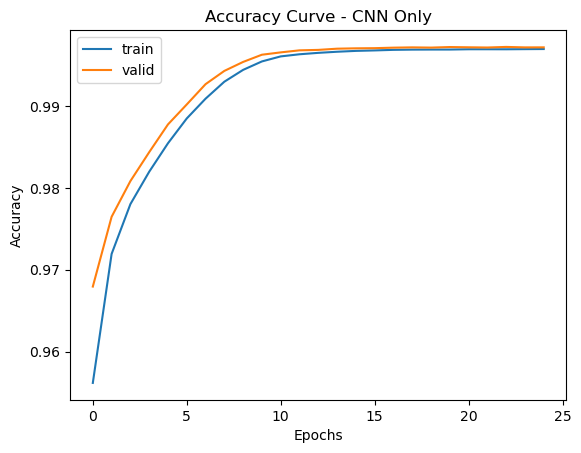

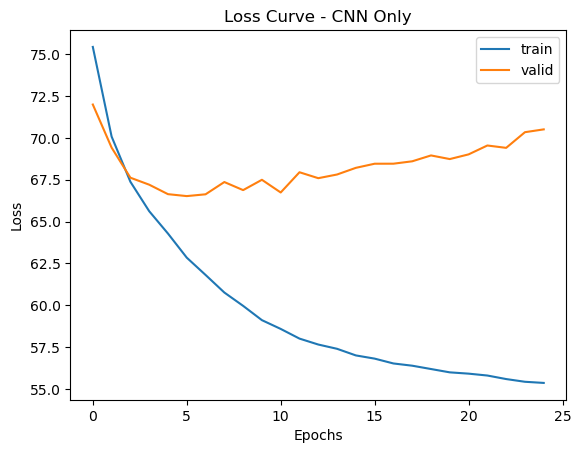

In [50]:
# CNN Only

import icd9_dl_model 

cnn_dropout = 0.25
learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="cnn", cnn_dropout_rate=cnn_dropout).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 25
file_name = "CNN Only"
threshold = 0.3


train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:04<00:00, 16.98it/s]


Training Loss: 74.4954. Validation Loss: 70.5724. 
Training Accuracy: 0.9594. Validation Accuracy: 0.9665. 
Training Precision: 0.0305. Validation Precision: 0.0375. 
Training Recall: 0.7151. Validation Recall: 0.7580. 
Training F1: 0.0585. Validation F1: 0.0714. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.21it/s]


Training Loss: 68.9912. Validation Loss: 68.3654. 
Training Accuracy: 0.9670. Validation Accuracy: 0.9723. 
Training Precision: 0.0382. Validation Precision: 0.0458. 
Training Recall: 0.7636. Validation Recall: 0.7666. 
Training F1: 0.0728. Validation F1: 0.0864. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.36it/s]


Training Loss: 66.5399. Validation Loss: 66.9948. 
Training Accuracy: 0.9725. Validation Accuracy: 0.9775. 
Training Precision: 0.0461. Validation Precision: 0.0544. 
Training Recall: 0.7695. Validation Recall: 0.7490. 
Training F1: 0.0869. Validation F1: 0.1013. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.05it/s]


Training Loss: 65.0278. Validation Loss: 66.2956. 
Training Accuracy: 0.9770. Validation Accuracy: 0.9814. 
Training Precision: 0.0544. Validation Precision: 0.0635. 
Training Recall: 0.7632. Validation Recall: 0.7253. 
Training F1: 0.1015. Validation F1: 0.1167. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.97it/s]


Training Loss: 63.4299. Validation Loss: 66.4897. 
Training Accuracy: 0.9814. Validation Accuracy: 0.9848. 
Training Precision: 0.0650. Validation Precision: 0.0746. 
Training Recall: 0.7416. Validation Recall: 0.6936. 
Training F1: 0.1194. Validation F1: 0.1346. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.50it/s]


Training Loss: 62.0190. Validation Loss: 66.1343. 
Training Accuracy: 0.9848. Validation Accuracy: 0.9885. 
Training Precision: 0.0770. Validation Precision: 0.0914. 
Training Recall: 0.7203. Validation Recall: 0.6474. 
Training F1: 0.1389. Validation F1: 0.1600. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.10it/s]


Training Loss: 60.8753. Validation Loss: 66.4372. 
Training Accuracy: 0.9881. Validation Accuracy: 0.9910. 
Training Precision: 0.0932. Validation Precision: 0.1089. 
Training Recall: 0.6858. Validation Recall: 0.5988. 
Training F1: 0.1637. Validation F1: 0.1839. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.96it/s]


Training Loss: 59.9091. Validation Loss: 66.9972. 
Training Accuracy: 0.9907. Validation Accuracy: 0.9930. 
Training Precision: 0.1124. Validation Precision: 0.1311. 
Training Recall: 0.6482. Validation Recall: 0.5480. 
Training F1: 0.1911. Validation F1: 0.2112. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.80it/s]


Training Loss: 59.0968. Validation Loss: 66.5312. 
Training Accuracy: 0.9925. Validation Accuracy: 0.9940. 
Training Precision: 0.1327. Validation Precision: 0.1455. 
Training Recall: 0.6110. Validation Recall: 0.5138. 
Training F1: 0.2174. Validation F1: 0.2262. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.09it/s]


Training Loss: 58.4721. Validation Loss: 66.7703. 
Training Accuracy: 0.9938. Validation Accuracy: 0.9949. 
Training Precision: 0.1515. Validation Precision: 0.1627. 
Training Recall: 0.5804. Validation Recall: 0.4773. 
Training F1: 0.2395. Validation F1: 0.2421. 
-----------------------------------
Epoch 11
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.39it/s]


Training Loss: 57.9253. Validation Loss: 66.9991. 
Training Accuracy: 0.9944. Validation Accuracy: 0.9954. 
Training Precision: 0.1653. Validation Precision: 0.1770. 
Training Recall: 0.5621. Validation Recall: 0.4583. 
Training F1: 0.2546. Validation F1: 0.2548. 
-----------------------------------
Epoch 12
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.24it/s]


Training Loss: 57.6253. Validation Loss: 67.7485. 
Training Accuracy: 0.9949. Validation Accuracy: 0.9957. 
Training Precision: 0.1774. Validation Precision: 0.1830. 
Training Recall: 0.5515. Validation Recall: 0.4427. 
Training F1: 0.2673. Validation F1: 0.2580. 
-----------------------------------
Epoch 13
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.32it/s]


Training Loss: 57.2614. Validation Loss: 67.8529. 
Training Accuracy: 0.9952. Validation Accuracy: 0.9959. 
Training Precision: 0.1860. Validation Precision: 0.1898. 
Training Recall: 0.5429. Validation Recall: 0.4327. 
Training F1: 0.2761. Validation F1: 0.2629. 
-----------------------------------
Epoch 14
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.54it/s]


Training Loss: 56.8647. Validation Loss: 67.4870. 
Training Accuracy: 0.9954. Validation Accuracy: 0.9961. 
Training Precision: 0.1929. Validation Precision: 0.1970. 
Training Recall: 0.5409. Validation Recall: 0.4237. 
Training F1: 0.2834. Validation F1: 0.2677. 
-----------------------------------
Epoch 15
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.62it/s]


Training Loss: 56.6323. Validation Loss: 67.8809. 
Training Accuracy: 0.9955. Validation Accuracy: 0.9962. 
Training Precision: 0.1988. Validation Precision: 0.2034. 
Training Recall: 0.5381. Validation Recall: 0.4221. 
Training F1: 0.2892. Validation F1: 0.2734. 
-----------------------------------
Epoch 16
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.89it/s]


Training Loss: 56.3183. Validation Loss: 69.0425. 
Training Accuracy: 0.9956. Validation Accuracy: 0.9962. 
Training Precision: 0.2031. Validation Precision: 0.2019. 
Training Recall: 0.5398. Validation Recall: 0.4168. 
Training F1: 0.2940. Validation F1: 0.2707. 
-----------------------------------
Epoch 17
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.86it/s]


Training Loss: 56.2204. Validation Loss: 68.1907. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9963. 
Training Precision: 0.2059. Validation Precision: 0.2078. 
Training Recall: 0.5407. Validation Recall: 0.4196. 
Training F1: 0.2969. Validation F1: 0.2768. 
-----------------------------------
Epoch 18
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.56it/s]


Training Loss: 56.0445. Validation Loss: 68.2590. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9964. 
Training Precision: 0.2080. Validation Precision: 0.2106. 
Training Recall: 0.5427. Validation Recall: 0.4091. 
Training F1: 0.2997. Validation F1: 0.2766. 
-----------------------------------
Epoch 19
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.23it/s]


Training Loss: 55.7717. Validation Loss: 68.5420. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9964. 
Training Precision: 0.2117. Validation Precision: 0.2119. 
Training Recall: 0.5428. Validation Recall: 0.4104. 
Training F1: 0.3034. Validation F1: 0.2785. 
-----------------------------------
Epoch 20
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.63it/s]


Training Loss: 55.6548. Validation Loss: 68.7851. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9962. 
Training Precision: 0.2142. Validation Precision: 0.2062. 
Training Recall: 0.5442. Validation Recall: 0.4233. 
Training F1: 0.3064. Validation F1: 0.2761. 
-----------------------------------
Epoch 21
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.30it/s]


Training Loss: 55.6475. Validation Loss: 68.8756. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9964. 
Training Precision: 0.2145. Validation Precision: 0.2145. 
Training Recall: 0.5510. Validation Recall: 0.4103. 
Training F1: 0.3071. Validation F1: 0.2795. 
-----------------------------------
Epoch 22
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.14it/s]


Training Loss: 55.4069. Validation Loss: 69.1077. 
Training Accuracy: 0.9959. Validation Accuracy: 0.9964. 
Training Precision: 0.2173. Validation Precision: 0.2119. 
Training Recall: 0.5487. Validation Recall: 0.4123. 
Training F1: 0.3102. Validation F1: 0.2786. 
-----------------------------------
Epoch 23
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:55<00:00,  1.43it/s]


Training Loss: 55.1559. Validation Loss: 69.4588. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2164. Validation Precision: 0.2112. 
Training Recall: 0.5524. Validation Recall: 0.4134. 
Training F1: 0.3098. Validation F1: 0.2768. 
-----------------------------------
Epoch 24
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.03it/s]


Training Loss: 55.1383. Validation Loss: 69.7004. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9962. 
Training Precision: 0.2154. Validation Precision: 0.2078. 
Training Recall: 0.5589. Validation Recall: 0.4198. 
Training F1: 0.3098. Validation F1: 0.2751. 
-----------------------------------
Epoch 25
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 37.31it/s]


Training Loss: 54.8542. Validation Loss: 69.6736. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2150. Validation Precision: 0.2084. 
Training Recall: 0.5628. Validation Recall: 0.4175. 
Training F1: 0.3099. Validation F1: 0.2766. 


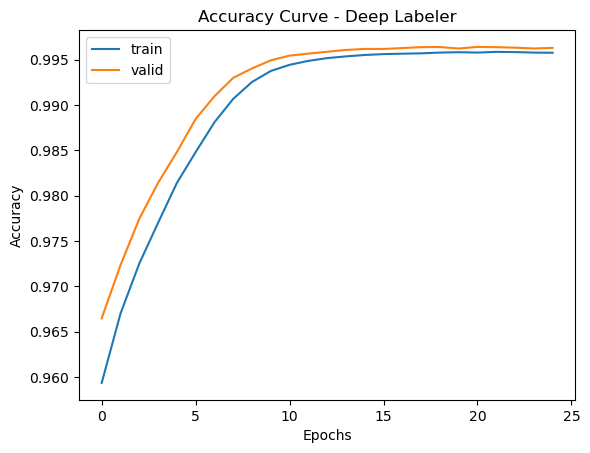

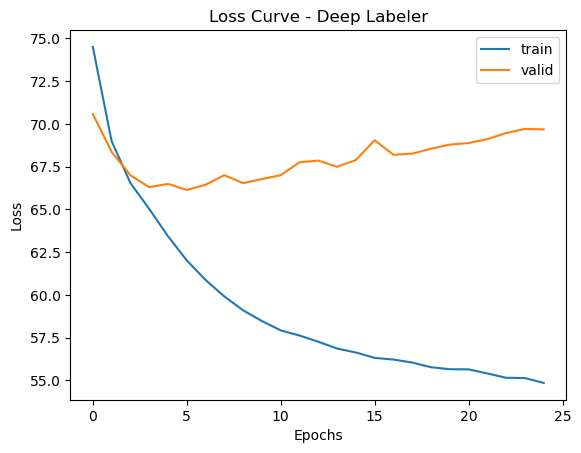

In [47]:
# Combined Deep Labeler

import icd9_dl_model 

learning_rate = 0.001
cnn_dropout = 0.25
d2v_dropout = 0.75
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], d2v_dropout_rate=d2v_dropout, cnn_dropout_rate=cnn_dropout).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 25
file_name = "Deep Labeler"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

In [49]:

from utils import score_model
model.eval() 

all_true_labels = []
all_outputs = []

with torch.no_grad(): 
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_outputs.extend(outputs.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

thresh_ls = [0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for i in thresh_ls:
  print('threshold:', i,
        *["{}: {}".format(name, num) for name, num in zip(
          ["accuracy", "precision", "recall","f1"],
          score_model(all_true_labels, all_outputs, threshold=i))])

threshold: 0.005 accuracy: 0.9955642566031778 precision: 0.1807947640677329 recall: 0.4567079996555574 f1: 0.25904331634054734
threshold: 0.05 accuracy: 0.9957236824071323 precision: 0.18552032165176366 recall: 0.447989322311202 f1: 0.26238313485433984
threshold: 0.1 accuracy: 0.9958949500177079 precision: 0.1911661274440848 recall: 0.43884009299922405 f1: 0.2663191518548273
threshold: 0.2 accuracy: 0.9962034948680022 precision: 0.20234503778807555 recall: 0.42017566520278904 f1: 0.2731490228183971
threshold: 0.3 accuracy: 0.9964836047628916 precision: 0.21396626849541828 recall: 0.40065013347110906 f1: 0.2789564800311763
threshold: 0.4 accuracy: 0.9967300532259968 precision: 0.2260016561564428 recall: 0.3818913740770232 f1: 0.2839581265806571
threshold: 0.5 accuracy: 0.9969553764908706 precision: 0.23878586820914108 recall: 0.362581534023636 f1: 0.2879416013471347
